Checkpoint path: ../audio_classification/models/Cnn14_DecisionLevelMax.pth
GPU number: 1


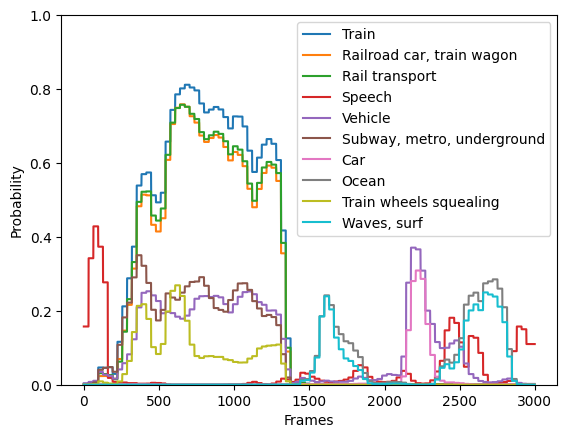

In [8]:
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
from moviepy.editor import VideoFileClip, ImageSequenceClip
import numpy as np
import torch
from panns_inference import SoundEventDetection, labels
import torchaudio
import matplotlib.pyplot as plt
import librosa

device = "cuda" if torch.cuda.is_available() else "cpu"

input_video_path = "./videos/input.mp4"
output_dir = "output"
file_list = os.listdir(output_dir)
for file_name in file_list:
    file_path = os.path.join(output_dir, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)

fps = 3
audio_path = "./videos/extracted_audio.wav"
video_clip = VideoFileClip(input_video_path)
audio = video_clip.audio
audio.write_audiofile(audio_path, verbose=False, logger=None)
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)
if os.path.exists(audio_path):
    os.remove(audio_path)

sed = SoundEventDetection(checkpoint_path='../audio_classification/models/Cnn14_DecisionLevelMax.pth', device=device, interpolate_mode='nearest')
framewise_output = sed.inference(audio)[0]
classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

idxes = np.argsort(classwise_output)[::-1]
idxes = idxes[0:10]
ix_to_lb = {i : label for i, label in enumerate(labels)}
lines = []
for idx in idxes:
    line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
    lines.append(line)

plt.legend(handles=lines)
plt.xlabel('Frames')
plt.ylabel('Probability')
plt.ylim(0, 1.)
plt.show()

In [9]:
print("Converting video to image array...")
# Convert video to images and extract timestamps
def video_to_images(video_path, output_dir, framewise_output, fps):
    clip = VideoFileClip(video_path)
    duration = clip.duration

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = []
    font_size = int(clip.size[1] * 0.05)  # 5% the height of the video
    font = ImageFont.truetype("arial.ttf", font_size)
    position = (10, 10)

    timestamps = []

    classwise_output = np.max(framewise_output, axis=0)
    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:10]

    for frame_number in range(int(duration * fps)):
        timestamp = frame_number / fps
        timestamps.append(timestamp)
        img = clip.get_frame(timestamp)
        img_pil = Image.fromarray(img)

        # Add this calculation before the timestamp_text
        frame_index = int(frame_number * len(framewise_output) / (duration * fps))
        if frame_index < len(framewise_output):
            frame_events = framewise_output[frame_index]
            top_label_idx = np.argmax(frame_events)
            top_label = labels[top_label_idx]
        else:
            top_label = "No Classification"

        # Use top_label in the timestamp_text
        # Convert timestamp to HH:MM:SS,mmm format
        hours = int(timestamp / 3600)
        minutes = int((timestamp % 3600) / 60)
        seconds = int(timestamp % 60)
        milliseconds = int((timestamp % 1) * 1000)
        timestamp_text = f"Time: {hours:02d}:{minutes:02d}:{seconds:02d},{milliseconds:03d} \nSound Effect: {top_label}"

        # Masking technique to draw inverted text on the image
        text_mask = Image.new("L", img_pil.size, 0)
        draw_mask = ImageDraw.Draw(text_mask)
        draw_mask.text(position, timestamp_text, fill=255, font=font)
        inverted_image = ImageOps.invert(img_pil)                           # Invert the colors in the region of the text
        final_image = Image.composite(inverted_image, img_pil, text_mask)   # Combine the original image with the inverted region using the text mask

        # Save the resultant image to path
        image_path = os.path.join(output_dir, f"f{frame_number:04d}.jpg")
        final_image.save(image_path, "JPEG")
        images.append(image_path)

    return images, clip.fps, fps, timestamps
images, original_fps, reduced_fps, timestamps = video_to_images(input_video_path, output_dir, framewise_output, fps=fps)
clip = ImageSequenceClip(images, fps=reduced_fps)
original_audio = VideoFileClip(input_video_path).audio
output_video_path = "./videos/output.mp4"
clip = clip.set_audio(original_audio)  # Set the original audio
clip.write_videofile(output_video_path, codec='libx264', verbose=False, logger=None)
print(f"Output video saved as {output_video_path}")

Converting video to image array...
Output video saved as ./videos/output.mp4


In [10]:
from IPython.display import display, Image, Audio
import cv2
import base64
import time

base64Frames = []
video = cv2.VideoCapture(output_video_path)
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
print(f"Length of image array: {len(base64Frames)}")

# check loading of video
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(1/48)